In [1]:
# import packages
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import f,chi2
import matplotlib.pyplot as plt
from numpy.linalg import inv, det
from sklearn.linear_model import LinearRegression
from statsmodels.multivariate.manova import MANOVA
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")

In [2]:
amit = pd.read_csv('amit.dat',header = None, delim_whitespace=True)
amit.columns = ['Y1', 'Y2', 'Z1', 'Z2', 'Z3', 'Z4', 'Z5']
amit.head()

,Y1,Y2,Z1,Z2,Z3,Z4,Z5
0,3389,3149,1,7500,220,0,140
1,1101,653,1,1975,200,0,100
2,1131,810,0,3600,205,60,111
3,596,448,1,675,160,60,120
4,896,844,1,750,185,70,83


# Model



$Y_{n \times m} = Z_{n \times (r+1)}\beta_{(r+1) \times m} + \epsilon_{n \times m}$ <br>
<br>
$E(\underset{\sim}{\epsilon_{(i)}}=\underset{\sim}{0} $ , $Var(\underset{\sim}{\epsilon_{(i)}})=\sigma_{ii}I$ , and $Cov(\underset{\sim}{\epsilon_{(i)}},\underset{\sim}{\epsilon_{(k)}}) = \sigma_{ik}I$ where $i,k=1,2,...,m$

$i$th response $\underset{\sim}{Y_{(i)}}$: <br>
$\underset{\sim}{Y_{(i)}} = Z \underset{\sim}{\beta_{(i)}} + \underset{\sim}{\epsilon_{(i)}}$ with $Cor(\underset{\sim}{\epsilon_{(i)}}) = \sigma_{ii}I, \; \underset{\sim}{\hat{\beta_{(i)}}} = (Z'Z)^{-1}Z'\underset{\sim}{Y_{(i)}}$

# Q1. Using the data in Table 7.6, answer the following questions. The data is in file ‘amit.dat’ with the variables of Y1, Y2, Z1, Z2, Z3, Z4, Z5.

## a. Perform a multivariate regression analysis. Analyze the residuals to check the multivariate normal assumption (Python and cqplot).

- Collecting Univariate Least Squares Estimates: <br>
$\hat{\beta}_{(r+1) \times m} = (Z'Z^{-1}Z')Y$ 

In [3]:
y = np.array(amit[['Y1', 'Y2']])
amit['constant']= np.ones(shape = (len(amit),))
z = amit[['constant','Z1', 'Z2', 'Z3', 'Z4', 'Z5']]
b_hat = np.linalg.inv(z.transpose()@z)@z.transpose()@y
print("The result of Multivariate Regression \n")
print("Estimated parameters for betas : \n")
print(b_hat)

The result of Multivariate Regression 

Estimated parameters for betas : 

             0            1
0 -2879.478246 -2728.708544
1   675.650781   763.029762
2     0.284851     0.306373
3    10.272133     8.896198
4     7.251171     7.205560
5     7.598240     4.987051


In [4]:
b1 = smf.ols("Y1~Z1+Z2+Z3+Z4+Z5", data=amit).fit()
b2 = smf.ols("Y2~Z1+Z2+Z3+Z4+Z5", data=amit).fit()
print(b1.params,'\n')
print(b2.params)

Intercept   -2879.478246
Z1            675.650781
Z2              0.284851
Z3             10.272133
Z4              7.251171
Z5              7.598240
dtype: float64 

Intercept   -2728.708544
Z1            763.029762
Z2              0.306373
Z3              8.896198
Z4              7.205560
Z5              4.987051
dtype: float64


The result of the multiple regression seems to match!

In [5]:
# Check the multivariate normal assumption

def cqplot(df):
    ''' calculate the confidence interval for correlation between two input variables.
    Parameters
    ----------
    df : input dataframe
    var1, var2, var3 : input variables
    plot_title : describes what variables were used for the chi-square plot
      
    Returns
    -------
    chi-square plot
    '''
    # step1: order the squared distances
    ## calculate the squared distances
    x = df.copy()
    m = df.mean()
    s = df.cov()
    s_inv = np.linalg.inv(s)
    d = np.zeros(len(df))
    for i in range(len(df)):
        d[i] = (x.iloc[i,]-m).dot(s_inv).dot(x.iloc[i,]-m)
    order = sorted(d)

    # step 2: calculate the probability values
    n = len(df)
    j = list(range(1,(n+1)))
    p = (np.asarray(j) - 0.5) /n

    # step 3: calculate the quantiles of the chi-square distribution
    order_d= np.asarray(order).reshape(-1,1)
    q = chi2.ppf(p, df = len(x.columns))
    # step 4: plot the pairs of observations
    plt.scatter(q,order_d)
    plt.title("Chi-square plot for the %s variables" %str(df.columns.to_list()))
    plt.ylabel('Sample Quantile')
    plt.xlabel('Quantile of Chi-Square distribution')
    
     # checking the straightness of the Chi-Square plot
    line_fitter = LinearRegression()
    line_fitter.fit(q.reshape(-1,1),order_d)
    plt.plot(q,line_fitter.predict(q.reshape(-1,1)), 'red')
    
    plt.show()

- Errors :<br>
$\hat{\epsilon} =  Y - Z \hat{\beta} = [\underset{\sim}{Y_{(1)}}- Z \underset{\sim}{\hat{\beta}_{(1)}} : \underset{\sim}{Y_{(2)}}- Z \underset{\sim}{\hat{\beta}_{(2)}} :\;  ... \; : \underset{\sim}{Y_{(m)}}- Z \underset{\sim}{\hat{\beta}_{(m)}}]$ 
- Residual vectors [$\underset{\sim}{\epsilon_{j1}}, \underset{\sim}{\epsilon_{j2}},..., \underset{\sim}{\epsilon_{jm}}$] can be examined for multivariate normality.

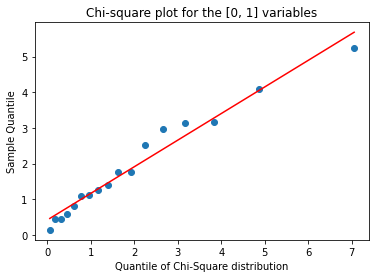

In [6]:
e = np.subtract(y , np.matmul(z,b_hat))
cqplot(e)

In general, it seems that the multivariate normal assumption holds for the amit data.

- Error Sum of Squares: <br>
$(Y-Z\hat{\beta})'(Y-Z\hat{\beta}) = \hat{\epsilon}' \hat{\epsilon}$ <br>
Diagonal elements: Error S.S. for univariate least squares $(\underset{\sim}{Y_{(i)}} - Z \underset{\sim}{\hat{\beta_{(i)}}})'(\underset{\sim}{Y_{(i)}} - Z \underset{\sim}{\hat{\beta_{(i)}}})$ is minimized. <br>
The generalized variance $|(Y-Z\hat{\beta})'(Y-Z\hat{\beta})|$ is also minimized.

- Predicted Values: $\hat{Y} = Z\hat{\beta} = Z(Z'Z)^{-1}Z'Y = HY$
- Residuals: $\hat{\epsilon} =Y -\hat{Y} = [I - Z(Z'Z)^{-1}Z']Y = (I-H)Y$
- Some Properties: <br>
$Z'\hat{\epsilon} = Z'[I-Z(Z'Z)^{-1}Z']Y = [Z'-Z']Y = 0$ $\therefore$ residuals are orthogonal to Z <br>
$\hat{Y}'\hat{\epsilon} = \hat{\beta}[I - Z(Z'Z)^{-1}Z']Y
= [\hat{\beta}'Z' - \hat{\beta}'Z' ]Y = 0$ $\therefore$ residuals are orthogonal to $\hat{Y}$

- Error Sum of Squares: <br>
$Y'Y = (\hat{Y}+ \hat{\epsilon})'(\hat{Y}+ \hat{\epsilon}) = \hat{Y}'\hat{Y} +  \hat{\epsilon}' \hat{\epsilon}$ <br>
$ \hat{\epsilon}' \hat{\epsilon}= Y'Y-\hat{Y}'\hat{Y}=  Y'Y - \hat{\beta}'Z'Z\hat{\beta}$


## b. Construct a 95% simultaneous confidence interval for E(Y1) at Z1=1, Z2=1200, Z3=140, Z4=70, Z5=85. (Python)

# Prediction:
$\hat{Y}_{n \times m} = Z \hat{\beta}_{(r+1)\times m}$

- Assume fixed values $\underset{\sim}{Z_0}_{(r+1)\times 1}$ of the predictor variables <br>
Then $\hat{\beta}'_{m \times (r+1)} \sim N_m( \beta ' \underset{\sim}{Z_0}, \underset{\sim}{Z_0}'(Z'Z)^{-1}\underset{\sim}{Z_0}\Sigma )$ <br>
<br>
- 100(1-$\alpha$)% simultaneous C.I. for $E(Y_i) = \underset{\sim}{Z_0}'\underset{\sim}{\beta}_{(i)}$ <br>
$= \underset{\sim}{Z_0}'\underset{\sim}{\beta_{(i)}} \pm \sqrt{\frac{m(n-r-1)}{n-r-m}F_{m,n-r-m}(\alpha)} \sqrt{\underset{\sim}{Z_0}'(Z'Z)^{-1})\underset{\sim}{Z_0} ( \frac{n}{n-r-1}\hat{\sigma_{ii}}} )$,   $i = 1,2,...,m$ <br>
, where $\underset{\sim}{\beta_{(i)}}$ is the $i$th column of $\hat{\beta}$ and $\sigma_{ii}$ is the $i$the diagonal element of $\hat{\Sigma}$

In [7]:
def sim_CI(z0,z,b_hat,i,alpha=0.05):
    b_i = b_hat.iloc[:,i-1]
    r, m = b_hat.shape
    r -= 1
    n = len(z)
    
    # sigma_ii
    sigma = e.T@e/ n
    
    # C.I.
    se = np.sqrt(((m*(n-r-1))/(n-r-m))* stats.f.isf(alpha, m, n-r-m)) * np.sqrt(z0.T@ np.linalg.inv(z.T@z)@z0 * (n/(n-r-1))*sigma[i-1][i-1])
    lbd, ubd = z0.T@b_i - se, z0.T@b_i + se
    
    print('The 100(1-%s) %% simultaneous C.I. for E(Y_%s):  \n   \r[%s,%s]' %(alpha, i, lbd[0][0], ubd[0][0]))

In [8]:
z0 = pd.DataFrame([1,1,1200,140,70,85])
sim_CI(z0, z, b_hat, i=1,alpha=0.05)

The 100(1-0.05) % simultaneous C.I. for E(Y_1):  
[319.02024178494423,1140.0293024397124]


## c. Construct a 95% simultaneous confidence interval for individual Y2 at Z1=1, Z2=1200, Z3=140, Z4=70, Z5=85. (Python)

- 100(1-$\alpha$)% simultaneous C.I. for the individual responses $ Y_{0i}= \underset{\sim}{Z_0}'\underset{\sim}{\beta}_{(i)} + \epsilon_{0i}$ <br>
$= \underset{\sim}{Z_0}'\underset{\sim}{\beta_{(i)}} \pm \sqrt{\frac{m(n-r-1)}{n-r-m}F_{m,n-r-m}(\alpha)} \sqrt{(1 + \underset{\sim}{Z_0}'(Z'Z)^{-1})\underset{\sim}{Z_0}) ( \frac{n}{n-r-1}\hat{\sigma_{ii}}} )$,   $i = 1,2,...,m$ <br>
, where $\underset{\sim}{\beta_{(i)}}$ is the $i$th column of $\hat{\beta}$ and $\sigma_{ii}$ is the $i$the diagonal element of $\hat{\Sigma}$

In [9]:
def sim_CI_ind(z0,z,b_hat,i,alpha=0.05):
    b_i = b_hat.iloc[:, i-1]
    r, m = b_hat.shape
    r -= 1
    n = len(z)
    
    # sigma_ii
    sigma = e.T@e/ n
    
    # C.I.
    se = np.sqrt(((m*(n-r-1))/(n-r-m))* stats.f.isf(alpha, m, n-r-m)) * np.sqrt((1 + z0.T@ np.linalg.inv(z.T@z)@z0 )* (n/(n-r-1))*sigma[i-1][i-1])
    lbd, ubd = z0.T@b_i - se, z0.T@b_i + se
    
    print('The 100(1-%s) %% simultaneous C.I. for Y_0%s:  \n   \r[%s,%s]' %(alpha, i, lbd[0][0], ubd[0][0]))

In [10]:
sim_CI_ind(z0, z, b_hat, i=2,alpha=0.05)

The 100(1-0.05) % simultaneous C.I. for Y_02:  
[-401.06528932426204,1552.5162238633404]


# d. Calculate $\hat{\Sigma} = \frac{1}{n} \hat{\epsilon}'\hat{\epsilon} = \frac{1}{n}(Y-Z \hat{\beta})'(Y-Z \hat{\beta})$ using Python

## Results

- Result 1 <br>
$E(\hat{\beta})= \beta$ <br>
$Cov(\underset{\sim}{\hat{\beta}_{(i)}}, \underset{\sim}{\hat{\beta}_{(k)}}) = \sigma_{ik} (Z'Z)^{-1}$ <br>
$E({\hat{\epsilon}})= 0 $ <br>
$E ( \frac{1}{n-r-1}\hat{\epsilon}'\hat{\epsilon})= \Sigma$ <br>
$\hat{\epsilon}$ and  $\hat{\beta}$ are uncorrelated.

- Result 2 <br>
If $\underset{\sim}{\epsilon_{j}}$ has a $N_m(\underset{\sim}{0},\Sigma)$, then$\hat{\beta} = (Z'Z)^{-1}Z'Y $ is the MLE of $\beta$ <br>
$\underset{\sim}{\hat{\beta}_{(i)}}  = N_{r+1}(\underset{\sim}{\beta_{(i)}}, \sigma_{ii}((Z'Z)^{-1})$
$\hat{\Sigma} = \frac{1}{n}(Y-Z\hat{\beta})'(Y-Z\hat{\beta})$ is an MLE of $\Sigma$, <br>
$n\hat{\Sigma}$ is distributed as Wishart: $W_{p,n-r-1}(\Sigma)$

In [11]:
n = len(z)
sigma = e.T@e/ n
sigma

,0,1
0,51176.959440,45039.792706
1,45039.792706,55335.817611


Note that 
- Multivariate regression requires no new computational problems.
- Univariate least squares $\underset{\sim}{\hat{\beta}_{(i)}}$ are computed individually for each response variable.
- Diagnositcs check must be done as in univariate regression.

# e. Compute the Wilk’s lambda value to test whether (Y1, Y2) are not dependent on (Z3, Z4, Z5). (Use Python).

- Hypothesis Testing 
    $H_0$ : responses do not depend on $Z_{q+1},Z_{q+2}, ... , Z_{r}$
    $\Leftrightarrow H_0: \beta_{(2 )} = 0$

## Full Model vs. Reduced Model 
- Set $Z = [Z_{1 \;\; n \times (q+1)}: Z_{2 \;\; n \times (q+1)}]$ <br>
Then $Z \beta = [Z_1 : Z_2][\beta_{(1)}, .., \beta_{(2)}]' = Z_1\beta_{1} + Z_2\beta_{(2)}$ <br>
Under $H_0$,  $Y= Z\beta_{(1)} + \epsilon$ <br>
<br>
- Let $E = n\hat{\Sigma} = (Y-Z\hat{\beta})'(Y-Z\hat{\beta})$ : Full Model <br>
$H = n(\hat{\Sigma_1} - \hat{\Sigma})$ <br>
where $E_1 = n\hat{\Sigma_1} = (Y-Z\hat{\beta}_{(1)})'(Y-Z\hat{\beta}_{(1)})$ : Under $H_0$ <br>
<br>
- Let $\lambda_1 \geq \lambda_2 \geq ... \geq \lambda_s$ be non-zero eigenvalues of $HE^{-1}, s= min(m,r-q)$


## Four Test Statistics

- Wilk's Lambda = $ \prod_{i=1}^{s} \frac{1}{1+\lambda_i} = \frac{|E|}{|E+H|}$ 
- Pillai's Trace = $\Sigma_{i=1}^{s} \frac{\lambda_i}{1+\lambda_i} = tr[H(H+E)^{-1}]$
- Hotelling-Lawley Trace = $\Sigma_{i=1}^{s} \lambda_i = tr[HE^{-1}]$
- Roy's Greatest Root = $\lambda_1$

In [12]:
# partition the variables  (Z3,Z4,Z5 is zero)
z1 = amit[['constant', 'Z1','Z2']]
b_hat1 = np.linalg.inv(z1.transpose()@z1)@z1.transpose()@y
e1 =  np.subtract(y , np.matmul(z1,b_hat1))

#full model
E = e.T@e
#reduced model
E1 = e1.T@e1
H = E1 - E

#Wilk's Lambda
wilk = det(E)/det(E+H)

print('Wilk\'s Lambda =', wilk  )

Wilk's Lambda = 0.4405021444258225


## f. Test the null hypothesis that (Y1, Y2) are not dependent on (Z3, Z4, Z5) at a=0.05. (Use Python).

- Sampling Distribution of the Wilk's Lambda <br>
Let $Z$ be pf full rank $r+1$ and $(r+1)+m \leq n$ <br>
Let $\epsilon$ be normally distributed <br>
Under $H_0$, <br>
$-[n-r-1-\frac{1}{2}(m-r+q+1)]ln(\Lambda^*) \sim \chi^{2}_{m(r-q)}$


In [13]:
def test_H0(alpha=0.05):
    _, q = z1.shape 
    q -=1
    r, m = b_hat.shape
    r -= 1
    stat =  -(n-r-1-(m-r+q+1)/2)*np.log(wilk)
    
    p_value = 1-chi2.cdf(stat, (m*(r-q)))
    if p_value <= 0.05 :
        print(f'Test Statistics : {np.round(stat,3)}')
        print(f'\nReject H0, p_value = {p_value}')
    else :
        print(f'Test Statistics : {np.round(stat,3)}')
        print(f'\nDo not reject H0, p_value = {p_value}' )
    
test_H0()

Test Statistics : 9.018

Do not reject H0, p_value = 0.17255488315212064
